In [ ]:
## Hypothesis_ less tuning around the axis!

In [2]:
from linares_plot import *

In [5]:
from __future__ import division
import numpy
import numpy as np
import os
from numpy import loadtxt, array, mean, zeros, shape, vstack, hstack, savetxt, reshape, dtype, unique, argmax, where, delete, roll, nanmean
from scipy.stats import zscore
import matplotlib.pyplot as plt
import pandas as pd
from numpy import *
from sklearn.decomposition import PCA
from matplotlib.pylab import *
from pickle import load,dump
from scipy.io import savemat
from scipy.stats import zscore
import seaborn as sns
from scikits.bootstrap import ci
#from circ_stats import *
import statsmodels.api as sm
from scipy.stats import *
import statsmodels.formula.api as smf
from itertools import chain
from scipy.stats import circmean,circvar
from cmath import phase
from  numpy import array
from scipy.stats import circmean,circvar,circstd
from numpy import *
from cmath import phase
from matplotlib.pylab import *


In [6]:
root = 'C:\\Users\\David\\Dropbox\\IDIBAPS\\3rings_ODR_christos' 

In [7]:

#functions
def get_rad(a):
    if a in range(1,9):
        return 1
    elif a in range (9, 17):
        return 2
    elif a in range(17, 25):
        return 3


def get_pos(a):
    if a in range(1,9):
        return a
    elif a in range (9, 17):
        return a-8
    elif a in range(17, 25):
        return a-16

    
    
def get_pref(cue_activity):
    #with this formula I take one vector from 0 for each position, where the module is the strength of the signal and the imaginary part the angle
    #after doing that I sum all of them to know the prefered one, this one is the angle, the v would be the module
    v=sum([exp(1j*c/8.0*2*pi)*(float(cue_activity[c])/sum(cue_activity)) for c in range(8)])
    angle=convert_2pi(phase(v))
    return (angle,abs(v))


def convert_2pi(angle):
    if angle < 0:
        angle = angle + 2*pi
    return angle



def len2(x):
	if type(x) is not type([]):
		if type(x) is not type(array([])):
			return -1
	return len(x)

def phase2(x):
	if not isnan(x):
		return phase(x)
	return nan

def circdist(angles1,angles2):
	if len2(angles2) < 0:
		if len2(angles1) > 0:
			angles2 = [angles2]*len(angles1)
		else:
			angles2 = [angles2]
			angles1 = [angles1]		
	if len2(angles1) < 0:
		angles1 = [angles1]*len(angles2)
	return amap(lambda a1,a2: phase2(exp(1j*a1)/exp(1j*a2)), angles1,angles2)


In [8]:
#neuron, position, fixation, cue, delay, sacade
position=0
fixation=1
cue=2
delay=3
sacade=4

directories=[ os.path.join(root, 'Albert25ODR', 'put1Way', 'A'), os.path.join(root, 'Albert25ODR',  'put1Way', 'B'),
             os.path.join(root,'Albert25ODR',  'apollo1Way', 'A'), os.path.join(root, 'Albert25ODR',  'apollo1Way', 'B')]


## Neurons to use
f=open( os.path.join(root,'Anova_inpSingle_2.txt'))
f=f.readlines()
neurons_to_use=loadtxt(f, dtype='str')

#list where to append the neurons that are significant
#neurons_selected=[[] for _ in range(0, len(directories))]
neurons_selected=[]
neurons_noselected=[]

total_neurons=len(neurons_to_use)

#excluded neurons
excluded_empty=[]
excluded_error=[]

#I need a neuron_pool. It has to be a list of strings (each one is a file with the data of a single neuron)
beta_neurons=[]

for NEURONS in range(0, len(neurons_to_use)):
    #decide the neurom
    label=neurons_to_use[NEURONS]
    label_monkey=label[1]
    label_set=label[2]
    label_neuron=label[0]
    #print label_neuron
    
    if label_monkey=='Apollo':
        os.chdir(root+'/Albert25ODR/apollo1Way')
        if label_set=='a':
            os.chdir(root+'/Albert25ODR/apollo1Way/A')
        if label_set=='b':
            os.chdir(root+'/Albert25ODR/apollo1Way/B')            
    
    if label_monkey=='Sput':
        os.chdir(root+'/Albert25ODR/sput1Way')
        if label_set=='a':
            os.chdir(root+'/Albert25ODR/sput1Way/A')
        if label_set=='b':
            os.chdir(root+'/Albert25ODR/sput1Way/B') 
    
    ###
    try: #error in the organization of the file
        data=loadtxt(label_neuron)
        if len(data)==0: #if empty file, pass
            excluded_empty.append(1)
            pass
        else:
            #exclude fixation
            data=data[data[:, position]!=0]
            if len(data)==0: #if empty file after excluding fixation, pass
                excluded_empty.append(1)
                pass
            else:
                #exclude trials with extra positions (25, 26, 27....)
                if sum(array(data[:,0]) > 24 )!=0:
                    excluded_error.append(1)
                    pass
                else:
                    data=data[array([data[i,0] in range(1,25) for i in range(0, len(data))])]
                    
                    if shape(data)[1]!=5: #if there are less columns than requires, pass
                        excluded_error.append(1)
                        pass
                    else:
                        #get the Y
                        fr_cue=data[:,cue]
                        fr_delay=data[:,delay]
                        
                        #get the regressors
                        RAD=[get_rad(data[i, position]) for i in range(0, len(data))]
                        POS=[int(get_pos(data[i, position])) for i in range(0, len(data))]
                        
                        #categorical_neurons
                        M=zeros((len(POS), 8))
                        list_uniques=[1,2,3,4,5,6,7,8]
                        for i in range(0, len(list_uniques) ):
                            M[:,i]=( array(POS)==list_uniques[i] )*1
                        
                        #decide if the Y is the firing rate of the cue or the one of the delay
                        cues=7
                        df = pd.DataFrame({"Y": fr_cue, "P1": M[:,0], "P2": M[:,1], "P3": M[:,2], "P4": M[:,3], "P5": M[:,4], "P6": M[:,5], "P7": M[:,6], "P8": M[:,7]})
                        #result = smf.ols(formula="Y ~ 0+ P1+ P2 + P3 + P4 + P5 + P6 + P7 + P8 ", data=df).fit()
                        result = smf.ols(formula="Y ~ P2 + P3 + P4 + P5 + P6 + P7 + P8 ", data=df).fit()
                        p_vals=[result.pvalues[j] for j in range(1,cues+1)] #I do not take the intercept
                        
                        # set the significance to accept the neurons
                        if sum(array(p_vals)<0.05) >0: 
                            neurons_selected.append(label_neuron)
                            beta_2=[result.params[par]**2 for par in range(1,cues+1)]
                            beta_neuron=sqrt(sum(beta_2))/mean(fr_cue)
                            beta_neurons.append([label_neuron, beta_neuron])
                        else:
                            neurons_noselected.append(label_neuron)
    
    ######
    except ValueError:
        excluded_error.append(1)
        pass
    except IOError:
        excluded_error.append(1)
        pass



C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in less
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: loadtxt: Empty input file: "1024000"

In [9]:
a=array(beta_neurons)
a_sorted=a[a[:,1].argsort()] ## sort them by firing rate
neurons_selected=a_sorted[:, 0] 

print('Percentage of neurons selected: ' + str( round( float(len(neurons_selected))/ float(total_neurons) *100, 1)  ) + '%')

Percentage of neurons selected: 31.8%


In [10]:
total_neurons

516

In [11]:
indexes_means_out=[]

#os.chdir('/home/david/Dropbox/IDIBAPS/3rings_ODR_christos')

### Now I am going to take the mean of these neurons in the  file means.out
os.chdir(root)
data=loadtxt("means.out", usecols=(1,2,3,4,5,6))

fix=1
cue_p=2
delay=3
sacc=4

#get the indexes of the usefull neurons 
for i in range(0, len(neurons_selected)):
    indexes_means_out.append(numpy.where(data[:,0]==float(neurons_selected[i])))

In [12]:
#########################################
#set the data to these interesting neurons
idx=list(chain.from_iterable(indexes_means_out))
idxs=list(chain.from_iterable(idx))
data=data[idxs, :]

In [13]:
############################################33
#ordenadas en tcs de acuerdo a uniq_n
uniq_n =  unique(data[:,0])
#here I "lose 11 neurons because some of them are repeated)
nneurons = len(uniq_n)
n_cues = 25

time=[cue_p,delay]
time=cue_p
tcs = zeros([nneurons,25])
cues_count = []
for ni,n in enumerate(uniq_n):
    #en data, give me the ones with the neuron label (have a boolean for each neuron)
    neuron_idx = data[:,0] == n
    for cue in range(n_cues):
        # in each spec neuron, the equal t the cue
        cue_idx = data[neuron_idx,1] == cue
        #append in the empty matrix --> in the data, the ones of the specific label and the specific cue, the mean of those neurons in the column of the cue 
        tcs[ni,cue] = mean(data[neuron_idx,cue_p][cue_idx])
        #how many cues in the same neuron?? in most there is just one, but i others there are more. Sum all together to know the total amount of cues
        cues_count.append(sum(cue_idx))



C:\Users\David\Anaconda3\envs\python3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:

#take off the one with not data at the cue, the uniqq_n_ok are the labels of the neurons of the tcs and tcs2
uniq_n_ok=uniq_n[sum(isnan(tcs),1)<1]
tcs=tcs[sum(isnan(tcs),1)<1]
tcs2=tcs

#take the preferred location
### another way to take the pref (Joao and Albert)
rings=[]
prefs=[]
positions=[ [1,2,3,4,5,6,7,8], [9,10,11,12,13,14,15,16], [17,18,19,20,21,22,23,24]] 
for i in range(0,len(tcs2)):
    var_rads=[circvar(tcs2[i, 1:9]), circvar(tcs2[i, 9:17]), circvar(tcs2[i, 17:25])]
    m=min(var_rads)
    ring=array([0,1,2])[array(var_rads)==m][0] 
    rings.append(ring)

    
    
    
rings=array(rings)

ring1 = find(concatenate([ones(8),zeros(17)]))+1
ring2 = find(concatenate([zeros(8),ones(8),zeros(9)]))+1
ring3 = find(concatenate([zeros(16),ones(8),[0]]))+1
ring_sel = [ring1,ring2,ring3]




num_neu=len(tcs2)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.


In [25]:
#apply the  formula for each neuron, once we have selected the preferred radius of neuron
cos_fit_prf = [get_pref(tcs2[n,ring_sel[rings[n]]])[0] for n in arange(num_neu)]

#Redefinition as there are few nans
tcs2=tcs2[~isnan(cos_fit_prf)]
rings=rings[~isnan(cos_fit_prf)]
cos_fit_prf=list(array(cos_fit_prf)[~isnan(cos_fit_prf)]) 
num_neu=len(cos_fit_prf)

#cos_fit_p = floor(array(cos_fit_prf)/(pi/4))
#cos_fit_p = ceil(array(cos_fit_prf)/(pi/4))
#round instead of floor
cos_fit_p = array([int(round(array(cos_fit_prf[i])/(pi/4))) for i in arange(num_neu)]) 

cos_fits = []
POS_pref = []
for r in range(3):
    # for each radius, sel is from 1 to 8 in the first rad, 9to 17 in the second and so on
    # with find I get all the indexes where the pref rad is the one that we want, with this index (n), I go to the correct
    # line of the tcs matrix. one there, I select all the neurons inside this radius. Now I have 8 frate. To this firing rates
    # I apply the function get_pref. I am going to apply this function for all the indexes n. n times the get_pref. Each time over 8 diff values.
    #the get ref function gives us two values. We get the second one, which is the population vector of the population
    #in each radius, one value por each neuron where the preferred is inside the radius
    sel = ring_sel[r]
    p= [get_pref(tcs2[n,sel])[1] for n in find(rings==r)]
    ang_ = [get_pref(tcs2[n,sel])[0] for n in find(rings==r)]
    cos_fits.append(p)
    POS_pref.append(ang_)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.


In [34]:
preferred_angles = concatenate([np.degrees(POS_pref[0]), np.degrees(POS_pref[1]), np.degrees(POS_pref[2])])

In [62]:
def circ_dist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)

def closest_ref(angle):
    mins_ = np.array([circ_dist(angle, 0), circ_dist(angle, 45), circ_dist(angle, 90), circ_dist(angle, 135), 
                       circ_dist(angle, 180), circ_dist(angle, 225), circ_dist(angle, 270), circ_dist(angle, 315)])
    
    min_distance = min(mins_)
    boole_ = mins_ == min_distance
    #
    ax_diag = np.array(['axis', 'diagonal', 'axis', 'diagonal', 'axis', 'diagonal', 'axis', 'diagonal' ])
    #
    pref_ = ax_diag[boole_][0]
    #
    return pref_



In [63]:
preferred_diagonal_axis = [closest_ref(preferred_angles[x]) for x in range(len(preferred_angles))]

In [64]:
s=amap(lambda x: sqrt(-2*np.log(x)),cos_fits) #std circular (this is the reason for the )
Y=concatenate(s)
df_ = pd.DataFrame({"std_circular": Y, "preff_axis": preferred_diagonal_axis})

model = smf.ols(formula="std_circular ~  preff_axis", data=df_).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           std_circular   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2710
Date:                Wed, 16 Feb 2022   Prob (F-statistic):              0.603
Time:                        19:54:40   Log-Likelihood:                -120.86
No. Observations:                 153   AIC:                             245.7
Df Residuals:                     151   BIC:                             251.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: The amap function was deprecated in version 2.2. Use numpy.array(list(map(...))) instead.
  """Entry point for launching an IPython kernel.


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\linares_plot.py:120: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
  ci= bootstraps.ci(df.groupby(x).get_group(x_idx)[y], statfunction=statistic, n_samples=reps,  alpha=1-CI)    # calculate the bootstrap (data no subject base)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\linares_plot.py:120: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
  ci= bootstraps.ci(df.groupby(x).get_group(x_idx)[y], statfunction=statistic, n_samples=reps,  alpha=1-CI)    # calculate the bootstrap (data no subject base)


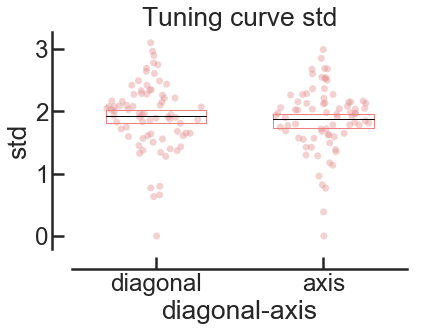

In [65]:
linares_plot(x='preff_axis', y='std_circular', order=['diagonal', 'axis'], CI=0.95,
             alpha=0.4, palette=['lightcoral'], df=df_, point_size=7,  reps=100)

plt.xlabel('diagonal-axis')
plt.ylabel('std')
plt.title('Tuning curve std')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')

In [66]:
import scipy
scipy.stats.ttest_ind(df_.loc[df_['preff_axis']=='diagonal', 'std_circular'], df_.loc[df_['preff_axis']=='axis', 'std_circular'] )

Ttest_indResult(statistic=0.5205901586369314, pvalue=0.6034148127597688)

In [67]:
X=concatenate([ones(len(x))*i for i,x in enumerate(cos_fits)])
df = pd.DataFrame({"std_circular": Y, "eccentricity": X, "preff_axis": preferred_diagonal_axis})
model = smf.ols(formula="std_circular ~  eccentricity*preff_axis", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           std_circular   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     2.426
Date:                Wed, 16 Feb 2022   Prob (F-statistic):             0.0679
Time:                        19:55:02   Log-Likelihood:                -117.35
No. Observations:                 153   AIC:                             242.7
Df Residuals:                     149   BIC:                             254.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [51]:
df

,eccentricity,preff_axis,std_circular
0,0.0,d,2.350575
1,0.0,d,1.376253
2,0.0,a,1.172411
3,0.0,d,1.397194
4,0.0,d,2.068878
...,...,...,...
148,2.0,d,2.779085
149,2.0,a,2.024961
150,2.0,a,2.682116
151,2.0,a,2.045018


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\linares_plot.py:158: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
  ci= bootstraps.ci(df.groupby(x).get_group(x_idx).groupby(hue).get_group(h_idx)[y], statfunction=statistic,  alpha=1-CI, n_samples=reps)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\linares_plot.py:158: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
  ci= bootstraps.ci(df.groupby(x).get_group(x_idx).groupby(hue).get_group(h_idx)[y], statfunction=statistic,  alpha=1-CI, n_samples=reps)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\linares_plot.py:158: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
  ci= bootstraps.ci(df.groupby(x).get_group(x_idx).groupby(hue).get_group(h_idx)[y], statfunction=statistic,  alpha=1-CI, n_samples=reps)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\linares_plot.py:158: InstabilityWarnin

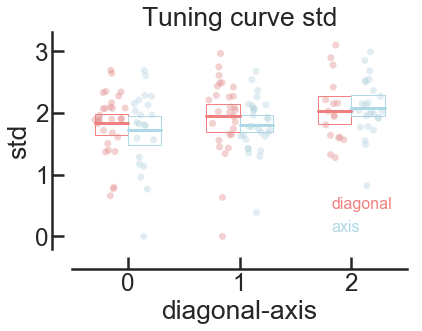

In [68]:
linares_plot(x= "eccentricity", y='std_circular',  hue='preff_axis', order = [0,1,2], hue_order=['diagonal', 'axis'], CI=0.95,
             alpha=0.4, palette=['lightcoral', 'lightblue'], df=df, point_size=7,  reps=100)

plt.xlabel('diagonal-axis')
plt.ylabel('std')
plt.title('Tuning curve std')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.tick_params(direction='in')

In [69]:
print(scipy.stats.ttest_ind(df.loc[(df['preff_axis']=='diagonal') & (df['eccentricity']==0), 'std_circular'], df.loc[(df['preff_axis']=='axis') & (df['eccentricity']==0), 'std_circular'] ) )
print(scipy.stats.ttest_ind(df.loc[(df['preff_axis']=='diagonal') & (df['eccentricity']==1), 'std_circular'], df.loc[(df['preff_axis']=='axis') & (df['eccentricity']==1), 'std_circular'] ) )
print(scipy.stats.ttest_ind(df.loc[(df['preff_axis']=='diagonal') & (df['eccentricity']==2), 'std_circular'], df.loc[(df['preff_axis']=='axis') & (df['eccentricity']==2), 'std_circular'] ) )

Ttest_indResult(statistic=0.7314540260792565, pvalue=0.4678495708314313)
Ttest_indResult(statistic=1.000264534745843, pvalue=0.32156307021510516)
Ttest_indResult(statistic=-0.37207015692751183, pvalue=0.7117568551836144)
